In [1]:
import torch

# 判断是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"当前使用的设备是: {device}")

当前使用的设备是: cuda


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

from torch import nn
import numpy as np
import torch
import os
import random
from tqdm import tqdm as tqdm
from IPython import display

from models.vgg import VGG_A
from models.vgg import VGG_BatchNorm # you need to implement this network
from data.loaders import get_cifar_loader

# ## Constants (parameters) initialization
device_id = [0]
num_workers = 0
batch_size = 128

# add our package dir to path 
module_path = os.path.dirname(os.getcwd())
home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

# Make sure you are using the right device.
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
device = torch.device("cuda:0".format(3) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
def unnormalize(img, mean, std):
    """Unnormalize a tensor image."""
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

Image batch shape: torch.Size([128, 3, 32, 32])
Label batch shape: torch.Size([128])
First 10 labels: [9, 0, 5, 8, 0, 4, 2, 8, 2, 3]


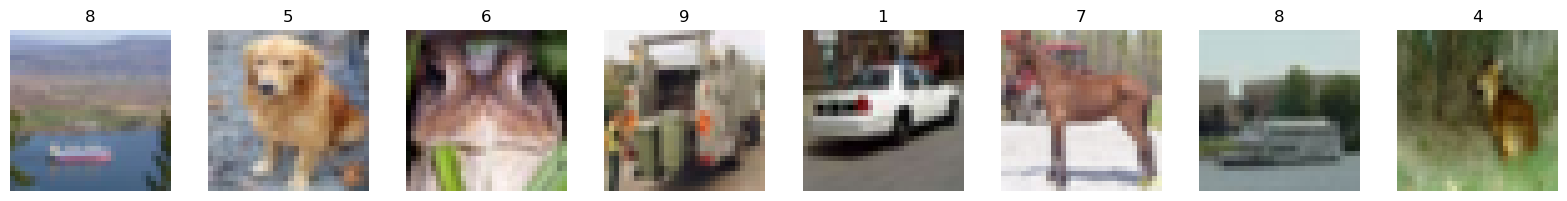

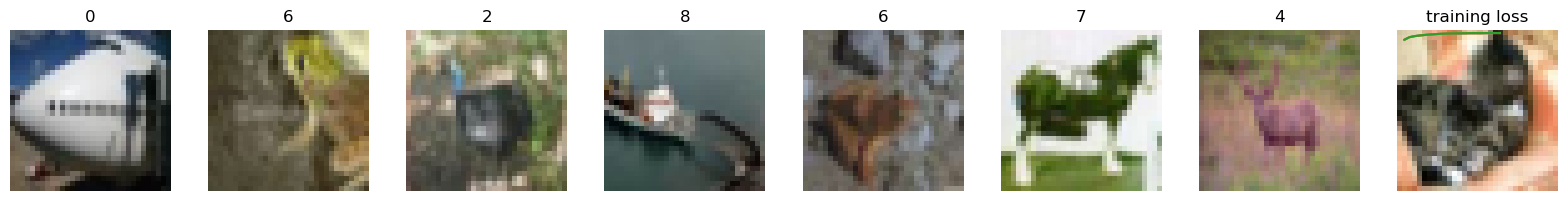

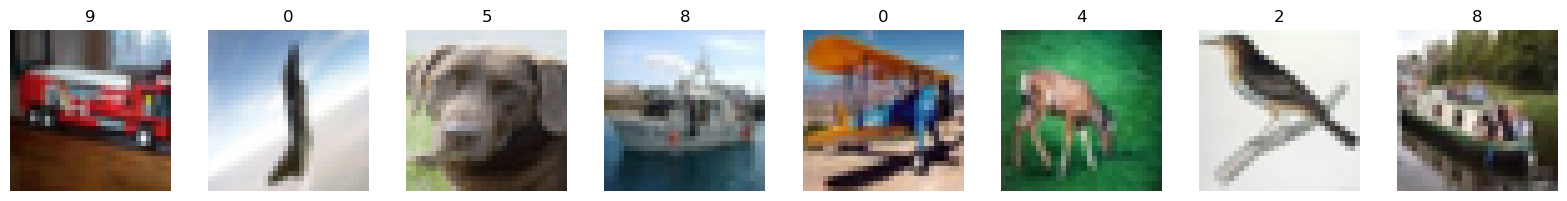

In [28]:
# Initialize your data loader and
# make sure that dataloader works
# as expected by observing one
# sample from it.
train_loader = get_cifar_loader(train=True)
val_loader = get_cifar_loader(train=False)
for X, y in train_loader:
    print(f"Image batch shape: {X.shape}")   # e.g., torch.Size([128, 3, 32, 32])
    print(f"Label batch shape: {y.shape}")   # e.g., torch.Size([128])
    print(f"First 10 labels: {y[:10].tolist()}")

    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    
    fig, axes = plt.subplots(1, 8, figsize=(16, 2))
    for i in range(8):
        img = unnormalize(X[i].clone(), mean, std)  # 反标准化，不影响原数据
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{y[i].item()}")
    
    plt.tight_layout()
    plt.show()
    break

In [5]:
print(len(train_loader)*128,len(train_loader))

50048 391


In [6]:
print(len(val_loader)*128)

10112


In [12]:
# This function is used to calculate the accuracy of model classification
def get_accuracy(data_loader):
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [13]:
# Set a random seed to ensure reproducible results
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [15]:

# We use this function to complete the entire
# training process. In order to plot the loss landscape,
# you need to record the loss value of each step.
# Of course, as before, you can test your model
# after drawing a training round and save the curve
# to observe the training
def train(model, optimizer, criterion, train_loader, val_loader, scheduler=None, epochs_n=100, best_model_path=None):
    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
   

    batches_n = len(train_loader)
    losses_list = []
    grads = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:
            scheduler.step()
        model.train()

        loss_list = []  # use this to record the loss value of each step
        grad = []  # use this to record the loss gradient of each step
        learning_curve[epoch] = 0  # maintain this to plot the training curve

        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            # You may need to record some variable values here
            # if you want to get loss gradient, use
            # grad = model.classifier[4].weight.grad.clone()
            ## --------------------
            # Add your code
            loss_value = loss.item()
            loss_list.append(loss_value)
            learning_curve[epoch] += loss_value
            
            loss.backward()
            
            grad_current = model.classifier[4].weight.grad.clone().cpu().numpy()
            grad.append(grad_current)
            ## -------------------
            
            optimizer.step()

        losses_list.append(loss_list)
        grads.append(grad)
        

        learning_curve[epoch] /= batches_n
        
       
        # model.eval()
        # 
        # # 训练集准确率
        # train_correct = 0
        # train_total = 0
        # with torch.no_grad():
        #     for data in train_loader:
        #         x, y = data[0].to(device), data[1].to(device)
        #         outputs = model(x)
        #         _, predicted = torch.max(outputs.data, 1)
        #         train_total += y.size(0)
        #         train_correct += (predicted == y).sum().item()
        # train_accuracy = train_correct / train_total
        # train_accuracy_curve[epoch] = train_accuracy
        # 
        # # 验证集准确率
        # val_correct = 0
        # val_total = 0
        # with torch.no_grad():
        #     for data in val_loader:
        #         x, y = data[0].to(device), data[1].to(device)
        #         outputs = model(x)
        #         _, predicted = torch.max(outputs.data, 1)
        #         val_total += y.size(0)
        #         val_correct += (predicted == y).sum().item()
        # val_accuracy = val_correct / val_total
        # val_accuracy_curve[epoch] = val_accuracy
        
        train_accuracy = get_accuracy(train_loader)
        val_accuracy = get_accuracy(val_loader)
        
        # 更新曲线数据
        train_accuracy_curve[epoch] = train_accuracy
        val_accuracy_curve[epoch] = val_accuracy
        
        
        # 更新最佳模型
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            if best_model_path is not None:
                torch.save(model.state_dict(), best_model_path)
        
        
        print(f'Epoch {epoch+1}/{epochs_n} - '
              f'Train Loss: {learning_curve[epoch]:.4f} | '
              f'Train Acc: {train_accuracy:.4f} | '
              f'Val Acc: {val_accuracy:.4f} | '
              f'Best Val Acc: {max_val_accuracy:.4f} ')
        
        # display.clear_output(wait=True)
        # f, axes = plt.subplots(1, 2, figsize=(15, 3))
        # axes[0].plot(learning_curve)
        # 
        # # Test your model and save figure here (not required)
        # # remember to use model.eval()
        # ## --------------------
        # # Add code as needed
        # axes[0].plot(learning_curve)
        # axes[0].set_title('Training Loss')
        # axes[0].set_xlabel('Epoch')
        # axes[0].set_ylabel('Loss')
        # 
        # # 绘制准确率曲线
        # axes[1].plot(train_accuracy_curve, label='Train')
        # axes[1].plot(val_accuracy_curve, label='Validation')
        # axes[1].set_title('Accuracy')
        # axes[1].set_xlabel('Epoch')
        # axes[1].set_ylabel('Accuracy')
        # axes[1].legend()
        # 
        # plt.show()
        ## --------------------

    return learning_curve, train_accuracy_curve, val_accuracy_curve, losses_list, grads


In [16]:
epo = 20


set_random_seeds(seed_value=2020, device=device)
model = VGG_BatchNorm()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
learning_curve, train_accuracy_curve, val_accuracy_curve, loss, grads = train(model, optimizer, criterion, train_loader, val_loader, epochs_n=epo,best_model_path='best_model.pth')


  5%|▌         | 1/20 [01:14<23:34, 74.46s/epoch]

Epoch 1/20 - Train Loss: 1.3787 | Train Acc: 0.6226 | Val Acc: 0.6174 | Best Val Acc: 0.6174 


 10%|█         | 2/20 [02:28<22:17, 74.33s/epoch]

Epoch 2/20 - Train Loss: 0.8719 | Train Acc: 0.7563 | Val Acc: 0.7247 | Best Val Acc: 0.7247 


 15%|█▌        | 3/20 [03:43<21:03, 74.35s/epoch]

Epoch 3/20 - Train Loss: 0.6678 | Train Acc: 0.7854 | Val Acc: 0.7369 | Best Val Acc: 0.7369 


 20%|██        | 4/20 [04:58<19:55, 74.71s/epoch]

Epoch 4/20 - Train Loss: 0.5362 | Train Acc: 0.8387 | Val Acc: 0.7731 | Best Val Acc: 0.7731 


 25%|██▌       | 5/20 [06:14<18:45, 75.06s/epoch]

Epoch 5/20 - Train Loss: 0.4371 | Train Acc: 0.8550 | Val Acc: 0.7783 | Best Val Acc: 0.7783 


 30%|███       | 6/20 [07:28<17:28, 74.89s/epoch]

Epoch 6/20 - Train Loss: 0.3511 | Train Acc: 0.8851 | Val Acc: 0.7875 | Best Val Acc: 0.7875 


 35%|███▌      | 7/20 [08:43<16:14, 74.97s/epoch]

Epoch 7/20 - Train Loss: 0.2775 | Train Acc: 0.9174 | Val Acc: 0.8064 | Best Val Acc: 0.8064 


 40%|████      | 8/20 [10:08<15:37, 78.11s/epoch]

Epoch 8/20 - Train Loss: 0.2157 | Train Acc: 0.9499 | Val Acc: 0.8218 | Best Val Acc: 0.8218 


 45%|████▌     | 9/20 [11:23<14:09, 77.21s/epoch]

Epoch 9/20 - Train Loss: 0.1710 | Train Acc: 0.9636 | Val Acc: 0.8238 | Best Val Acc: 0.8238 


 50%|█████     | 10/20 [12:38<12:45, 76.58s/epoch]

Epoch 10/20 - Train Loss: 0.1346 | Train Acc: 0.9562 | Val Acc: 0.8129 | Best Val Acc: 0.8238 


 55%|█████▌    | 11/20 [13:54<11:26, 76.27s/epoch]

Epoch 11/20 - Train Loss: 0.1088 | Train Acc: 0.9732 | Val Acc: 0.8183 | Best Val Acc: 0.8238 


 60%|██████    | 12/20 [15:10<10:08, 76.06s/epoch]

Epoch 12/20 - Train Loss: 0.0920 | Train Acc: 0.9477 | Val Acc: 0.7905 | Best Val Acc: 0.8238 


 65%|██████▌   | 13/20 [16:24<08:48, 75.46s/epoch]

Epoch 13/20 - Train Loss: 0.0836 | Train Acc: 0.9537 | Val Acc: 0.8033 | Best Val Acc: 0.8238 


 70%|███████   | 14/20 [17:38<07:30, 75.01s/epoch]

Epoch 14/20 - Train Loss: 0.0666 | Train Acc: 0.9785 | Val Acc: 0.8210 | Best Val Acc: 0.8238 


 75%|███████▌  | 15/20 [18:52<06:13, 74.78s/epoch]

Epoch 15/20 - Train Loss: 0.0596 | Train Acc: 0.9742 | Val Acc: 0.8174 | Best Val Acc: 0.8238 


 80%|████████  | 16/20 [20:06<04:58, 74.67s/epoch]

Epoch 16/20 - Train Loss: 0.0576 | Train Acc: 0.9834 | Val Acc: 0.8224 | Best Val Acc: 0.8238 


 85%|████████▌ | 17/20 [21:20<03:43, 74.43s/epoch]

Epoch 17/20 - Train Loss: 0.0576 | Train Acc: 0.9777 | Val Acc: 0.8078 | Best Val Acc: 0.8238 


 90%|█████████ | 18/20 [22:36<02:29, 74.74s/epoch]

Epoch 18/20 - Train Loss: 0.0474 | Train Acc: 0.9909 | Val Acc: 0.8304 | Best Val Acc: 0.8304 


 95%|█████████▌| 19/20 [23:51<01:14, 74.86s/epoch]

Epoch 19/20 - Train Loss: 0.0443 | Train Acc: 0.9744 | Val Acc: 0.8105 | Best Val Acc: 0.8304 


100%|██████████| 20/20 [25:21<00:00, 76.05s/epoch]

Epoch 20/20 - Train Loss: 0.0456 | Train Acc: 0.9757 | Val Acc: 0.8089 | Best Val Acc: 0.8304 


In [17]:
print(train_accuracy_curve)

[0.62264, 0.75632, 0.78538, 0.83868, 0.85504, 0.88512, 0.91738, 0.94988, 0.96362, 0.95624, 0.97322, 0.94766, 0.95374, 0.97852, 0.97416, 0.98342, 0.97774, 0.9909, 0.9744, 0.97572]


In [18]:
print(val_accuracy_curve)

[0.6174, 0.7247, 0.7369, 0.7731, 0.7783, 0.7875, 0.8064, 0.8218, 0.8238, 0.8129, 0.8183, 0.7905, 0.8033, 0.821, 0.8174, 0.8224, 0.8078, 0.8304, 0.8105, 0.8089]


In [19]:
print(learning_curve)

[1.3786971473023104, 0.87190798572872, 0.6678484371098716, 0.5362229737479364, 0.43709846713658795, 0.3510993585333495, 0.2775211856912469, 0.2157058410937219, 0.1709594884339501, 0.13462957028118547, 0.10878712271371156, 0.09201159298210346, 0.08359809550206604, 0.06659843963797173, 0.05964616118082324, 0.05756534534134924, 0.057580278089503424, 0.047437461539971956, 0.044311853102765635, 0.04558187292393326]


In [20]:
print(len(loss),len(loss[0]))

20 391


In [21]:
print(len(grads),len(grads[0]))

20 391


In [22]:
print(len(grads[0][0][0]))

512


验证保存模型：

In [23]:
model2 = VGG_BatchNorm().to(device)
model2.load_state_dict(torch.load('best_model_vggbn.pth'))
model2.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for data in val_loader:
        x, y = data[0].to(device), data[1].to(device)
        outputs = model2(x)
        _, predicted = torch.max(outputs.data, 1)
        val_total += y.size(0)
        val_correct += (predicted == y).sum().item()
val_accuracy = val_correct / val_total
print(val_accuracy)


0.8304


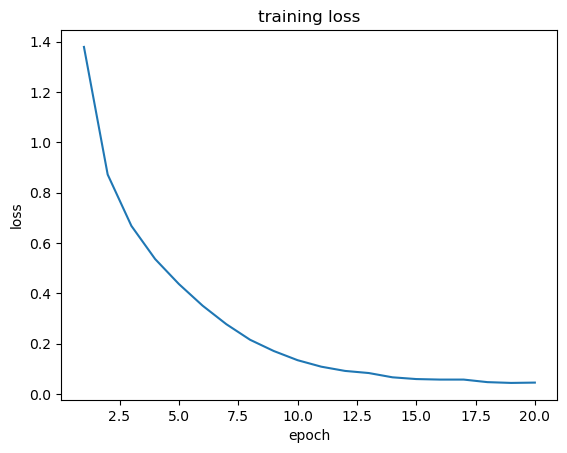

In [29]:
import matplotlib.pyplot as plt

x_index=range(1,21)

plt.plot(x_index, learning_curve, label='Train loss')
plt.title('training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

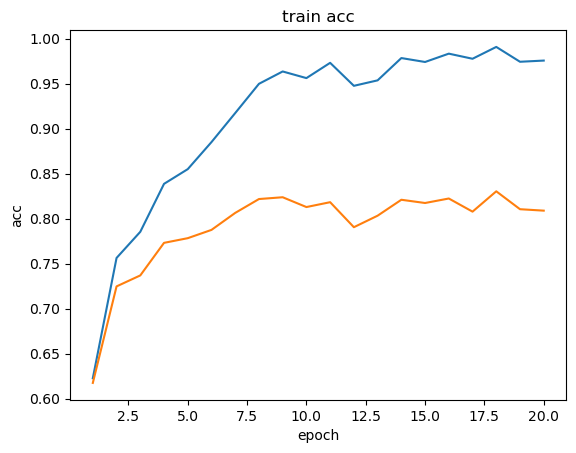

In [30]:
plt.plot(x_index, train_accuracy_curve, label='train acc')
plt.plot(x_index, val_accuracy_curve, label='val acc')
plt.title('train and val acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

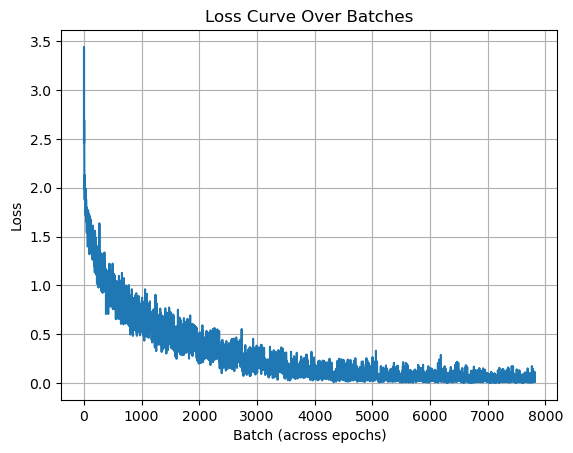

In [31]:
flattened_loss = [l for epoch in loss for l in epoch]

plt.plot(flattened_loss)
plt.title("Loss Curve Over Batches")
plt.xlabel("Batch (across epochs)")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [32]:
loss_save_path = './loss_path'
grad_save_path = './grad_path'
train_loss_save_path = './train_loss_path'
train_acc_save_path = './train_acc_path'
val_acc_save_path = './val_acc_path'

os.makedirs(loss_save_path, exist_ok=True)
os.makedirs(grad_save_path, exist_ok=True)
os.makedirs(train_loss_save_path, exist_ok=True)
os.makedirs(train_acc_save_path, exist_ok=True)
os.makedirs(val_acc_save_path, exist_ok=True)

np.savetxt(os.path.join(loss_save_path, 'loss_vggbn.txt'), loss, fmt='%s', delimiter=' ')
# np.savetxt(os.path.join(grad_save_path, 'grads_vggA.txt'), grads, fmt='%s', delimiter=' ')
np.save(os.path.join(grad_save_path, "grads_vggbn.npy"), grads)
np.savetxt(os.path.join(train_loss_save_path, 'train_loss_vggbn.txt'), learning_curve, delimiter=' ')
np.savetxt(os.path.join(train_acc_save_path, 'train_acc_vggbn.txt'), train_accuracy_curve, delimiter=' ')
np.savetxt(os.path.join(val_acc_save_path, 'val_acc_vggbn.txt'), val_accuracy_curve, delimiter=' ')



In [39]:
# Maintain two lists: max_curve and min_curve,
# select the maximum value of loss in all models
# on the same step, add it to max_curve, and
# the minimum value to min_curve
# 加载不同模型的损失数据（假设均为二维数组：epochs × batches）
loss_vggA = np.loadtxt('loss_path/loss_vggA.txt')    # 示例形状 (20, 391)
loss_vggbn = np.loadtxt('loss_path/loss_vggbn.txt')  # 示例形状 (20, 391)

# 合并所有模型的损失数据（可扩展添加更多模型）
all_losses = [loss_vggA, loss_vggbn]  # 列表中的每个元素形状需一致
# 将每个模型的损失展平为步骤序列（假设所有模型训练步数相同）
all_losses_flattened = [loss.flatten() for loss in all_losses]  # 每个元素形状 (20*391,)

# 转换为二维数组（models × steps）
all_losses_array = np.stack(all_losses_flattened, axis=0)  # 形状 (2, 7820)


min_curve = []
max_curve = []
## --------------------
# Add your code
# 计算每个步骤的极值
max_curve = np.max(all_losses_array, axis=0)  # 形状 (7820,)
min_curve = np.min(all_losses_array, axis=0)

## --------------------

# Use this function to plot the final loss landscape,
# fill the area between the two curves can use plt.fill_between()
def plot_loss_landscape(max_curve, min_curve):
    ## --------------------
    # Add your code
    plt.figure(figsize=(12, 6))
    
    # 生成步骤序列
    steps = np.arange(len(max_curve))
    
    # 填充极值区域
    plt.fill_between(
        steps,
        min_curve,
        max_curve,
        color="skyblue",
        alpha=0.3,
        label="Loss Range"
    )
    
    # 绘制极值曲线（可选）
    plt.plot(steps, max_curve, "r--", lw=1, label="Max Loss")
    plt.plot(steps, min_curve, "b--", lw=1, label="Min Loss")
    
    # 美化图表
    plt.title("Loss Landscape Comparison (VGG_A vs VGG_BN)")
    plt.xlabel("Training Step")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    ## --------------------
    pass

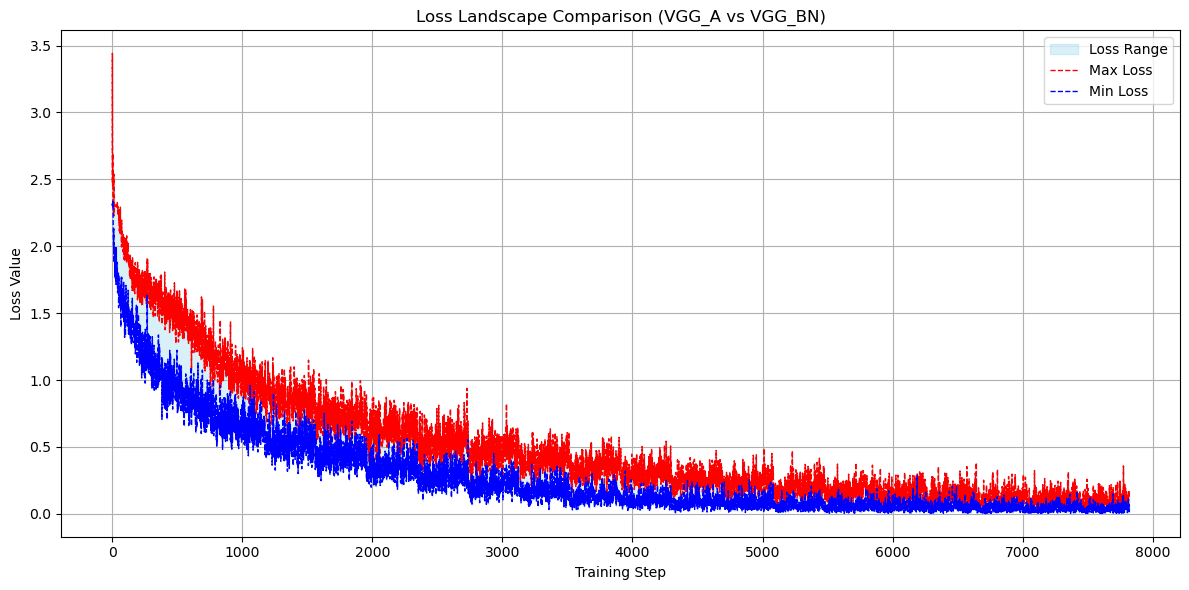

In [40]:
plot_loss_landscape(max_curve, min_curve)

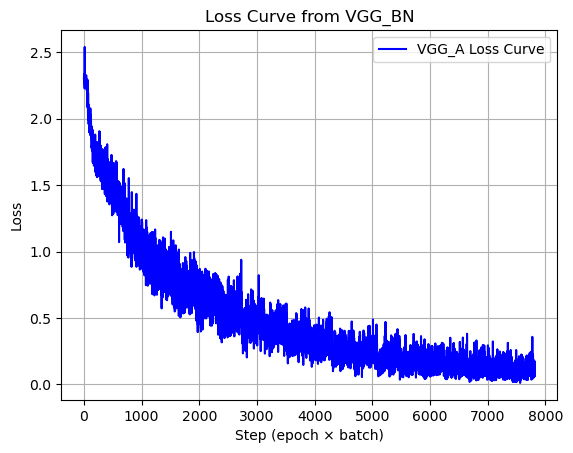

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# 加载 loss 文件
loss_path = 'loss_path/loss_vggA.txt'
loss = np.loadtxt(loss_path)  # 自动按空格读取为二维数组

# 展平成 1D 曲线
flattened_loss = loss.flatten()

plt.plot(flattened_loss, label='VGG_A Loss Curve', color='blue')
plt.title("Loss Curve from VGG_BN")
plt.xlabel("Step (epoch × batch)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

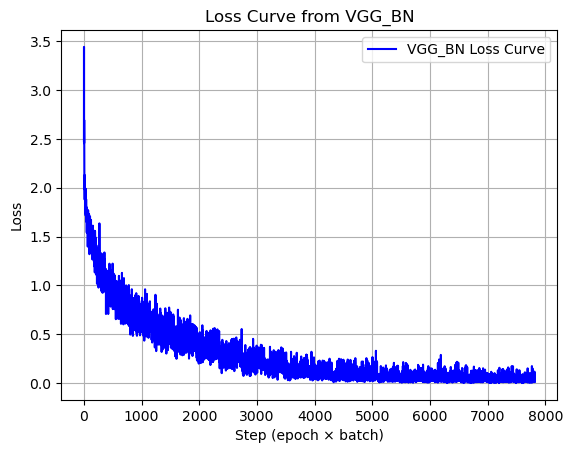

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# 加载 loss 文件
loss_path = 'loss_path/loss_vggbn.txt'
loss = np.loadtxt(loss_path)  # 自动按空格读取为二维数组

# 展平成 1D 曲线
flattened_loss = loss.flatten()

plt.plot(flattened_loss, label='VGG_BN Loss Curve', color='blue')
plt.title("Loss Curve from VGG_BN")
plt.xlabel("Step (epoch × batch)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

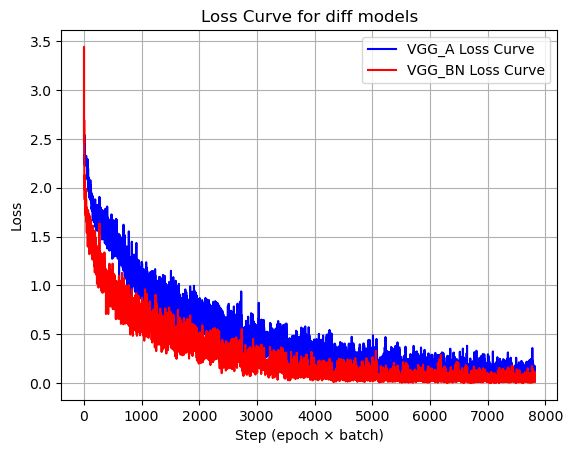

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# 加载 loss 文件
loss_path = 'loss_path/loss_vggA.txt'
loss_VGGA = np.loadtxt(loss_path)  # 自动按空格读取为二维数组

# 展平成 1D 曲线
flattened_loss_VGGA = loss_vggA.flatten()

# 加载 loss 文件
loss_path = 'loss_path/loss_vggbn.txt'
loss_VGGBN = np.loadtxt(loss_path)  # 自动按空格读取为二维数组

# 展平成 1D 曲线
flattened_loss_VGGBN = loss_VGGBN.flatten()


plt.plot(flattened_loss_VGGA, label='VGG_A Loss Curve', color='blue')
plt.plot(flattened_loss_VGGBN, label='VGG_BN Loss Curve', color='red')
plt.title("Loss Curve for diff models")
plt.xlabel("Step (epoch × batch)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

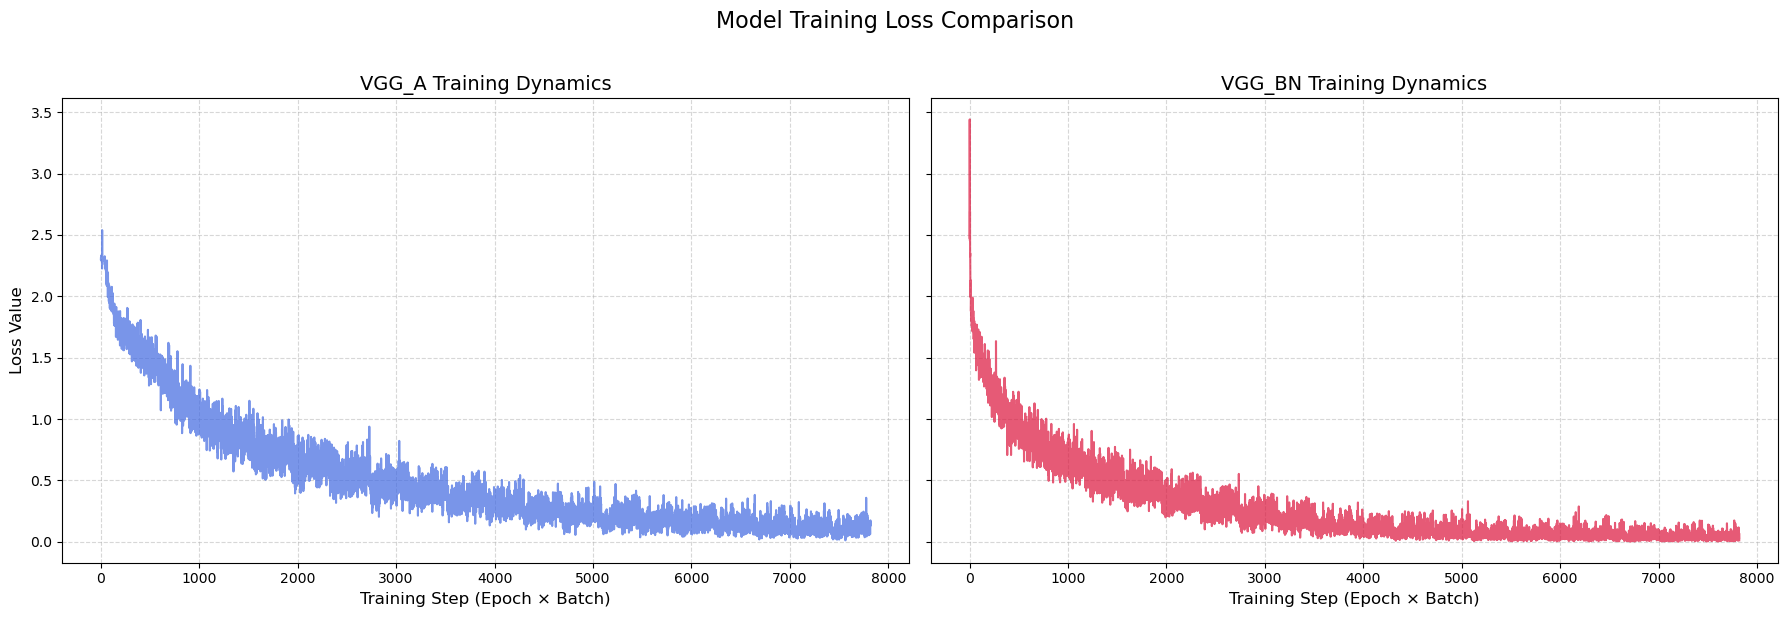

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# 加载数据
loss_vggA = np.loadtxt('loss_path/loss_vggA.txt').flatten()  # (epochs*batches,)
loss_vggbn = np.loadtxt('loss_path/loss_vggbn.txt').flatten()

# 创建对比子图 (1行2列)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# ================= 左子图：VGG_A =================
ax1.plot(loss_vggA, color='royalblue', alpha=0.7, label='VGG_A')
ax1.set_title("VGG_A Training Dynamics", fontsize=14)
ax1.set_xlabel("Training Step (Epoch × Batch)", fontsize=12)
ax1.set_ylabel("Loss Value", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)

# # 添加统计信息
# mean_loss = np.mean(loss_vggA)
# ax1.axhline(mean_loss, color='darkblue', linestyle='--', 
#            label=f'Mean Loss: {mean_loss:.2f}')
# ax1.legend(loc='upper right')

# ================= 右子图：VGG_BN =================
line_vggbn = ax2.plot(loss_vggbn, color='crimson', alpha=0.7, label='VGG_BN')[0]
ax2.set_title("VGG_BN Training Dynamics", fontsize=14)
ax2.set_xlabel("Training Step (Epoch × Batch)", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)

# # 添加动态分析
# window_size = 500  # 滑动窗口大小
# smoothed = np.convolve(loss_vggbn, np.ones(window_size)/window_size, mode='valid')
# ax2.plot(smoothed, color='black', linewidth=2, 
#         label=f'{window_size}-step Moving Avg')
# 
# # 标注收敛阶段
# converge_start = np.argmin(smoothed) + window_size//2
# ax2.axvline(converge_start, color='green', linestyle=':', 
#            label=f'Convergence Start: Step {converge_start}')
# ax2.legend(loc='upper right')

# ================= 全局设置 =================
plt.suptitle("Model Training Loss Comparison", fontsize=16, y=1.02)
plt.tight_layout()

plt.show()

可视化grad:

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_and_calculate_norms(grad_path):
    """加载梯度数据并计算各批次范数"""
    grads = np.load(grad_path)  # 形状 (20, 391, 10, 512)
    
    # 计算每个batch的梯度范数（保留epoch和batch维度）
    batch_norms = np.linalg.norm(grads, axis=(2,3))  # 结果形状 (20, 391)
    
    # 计算每个epoch的平均范数
    epoch_norms = batch_norms.mean(axis=1)  # 形状 (20,)
    
    return batch_norms, epoch_norms

# 加载两个模型的梯度范数
vgga_batch_norms, vgga_epoch_norms = load_and_calculate_norms('grad_path/grads_vggA.npy')
vggbn_batch_norms, vggbn_epoch_norms = load_and_calculate_norms('grad_path/grads_vggbn.npy')

In [57]:
# 展平 batch_norms（每个是 2D）
vgga_batch_flat = np.array(vgga_batch_norms).flatten()
vggbn_batch_flat = np.array(vggbn_batch_norms).flatten()

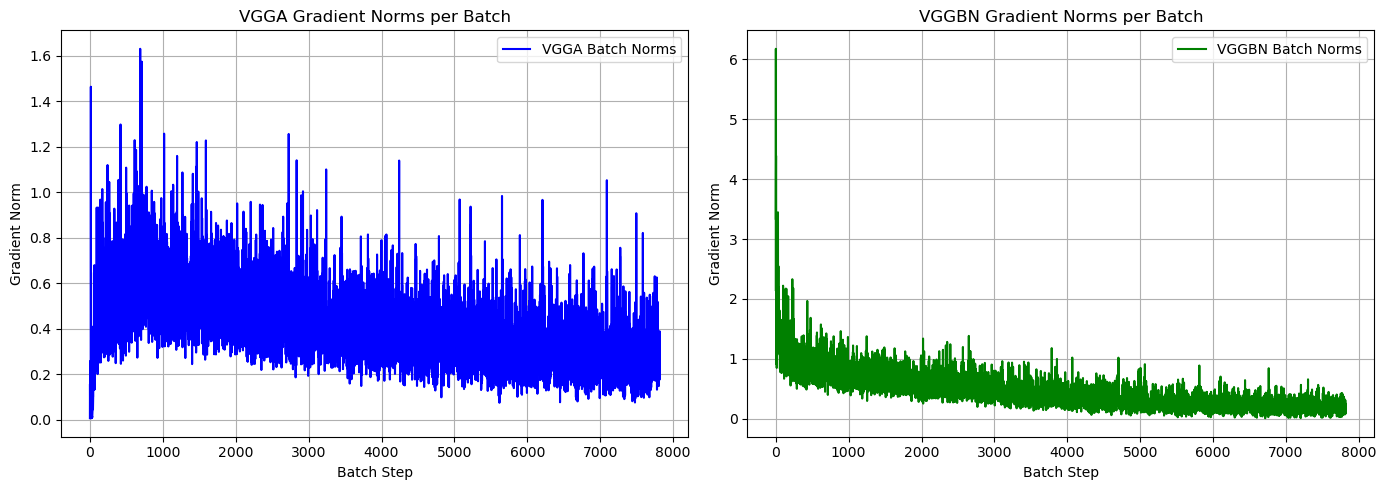

In [60]:
plt.figure(figsize=(14, 5))

# 左侧：VGGA
plt.subplot(1, 2, 1)
plt.plot(vgga_batch_flat, label='VGGA Batch Norms', color='blue')
plt.title("VGGA Gradient Norms per Batch")
plt.xlabel("Batch Step")
plt.ylabel("Gradient Norm")
plt.grid(True)
plt.legend()

# 右侧：VGGBN
plt.subplot(1, 2, 2)
plt.plot(vggbn_batch_flat, label='VGGBN Batch Norms', color='green')
plt.title("VGGBN Gradient Norms per Batch")
plt.xlabel("Batch Step")
plt.ylabel("Gradient Norm")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

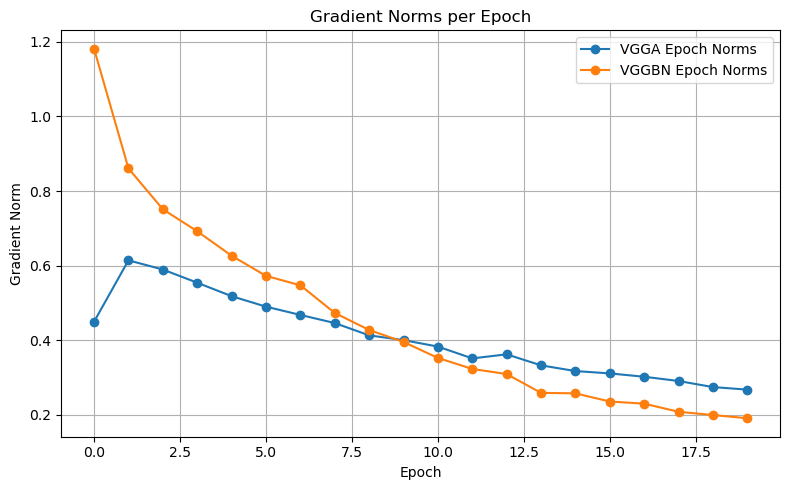

In [59]:
plt.figure(figsize=(8, 5))
plt.plot(vgga_epoch_norms, label='VGGA Epoch Norms', marker='o')
plt.plot(vggbn_epoch_norms, label='VGGBN Epoch Norms', marker='o')
plt.title("Gradient Norms per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
def plot_trend_comparison():
    plt.figure(figsize=(15, 6))
    
    # 滑动平均处理
    window_size = 50
    vgga_smooth = np.convolve(vgga_batch_norms.flatten(), 
                             np.ones(window_size)/window_size, mode='valid')
    vggbn_smooth = np.convolve(vggbn_batch_norms.flatten(),
                              np.ones(window_size)/window_size, mode='valid')
    
    # 趋势对比
    plt.plot(vgga_smooth, color='blue', alpha=0.7, label='VGG_A')
    plt.plot(vggbn_smooth, color='red', alpha=0.7, label='VGG_BN')
    
    plt.title("Smoothed Gradient Norm Trends", fontsize=14)
    plt.xlabel("Training Step (Batch)", fontsize=12)
    plt.ylabel("Gradient Norm", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

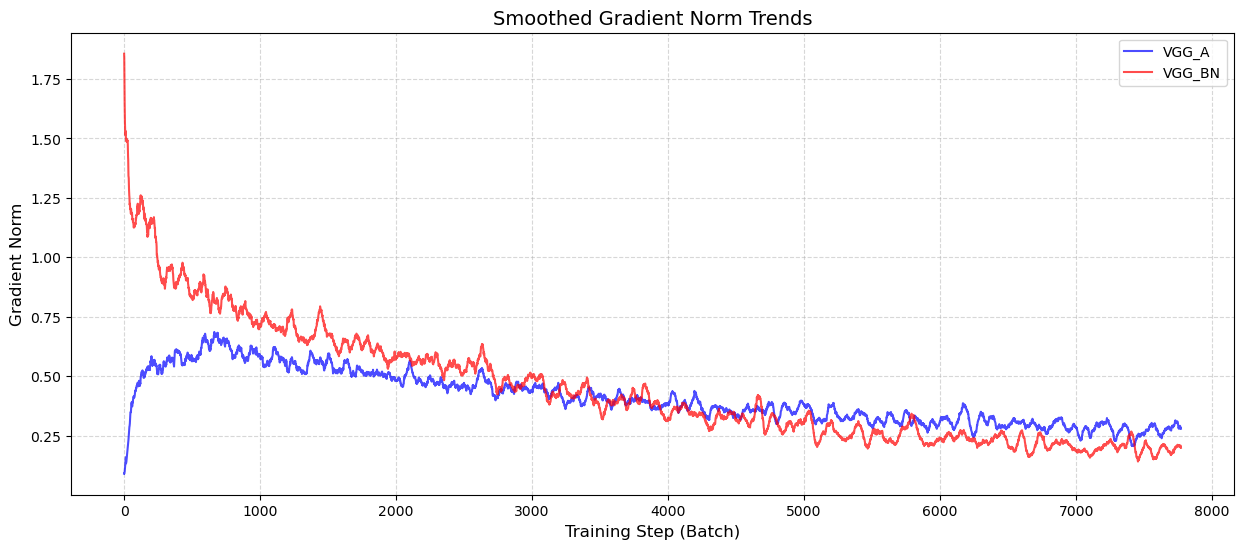

In [64]:
plot_trend_comparison()

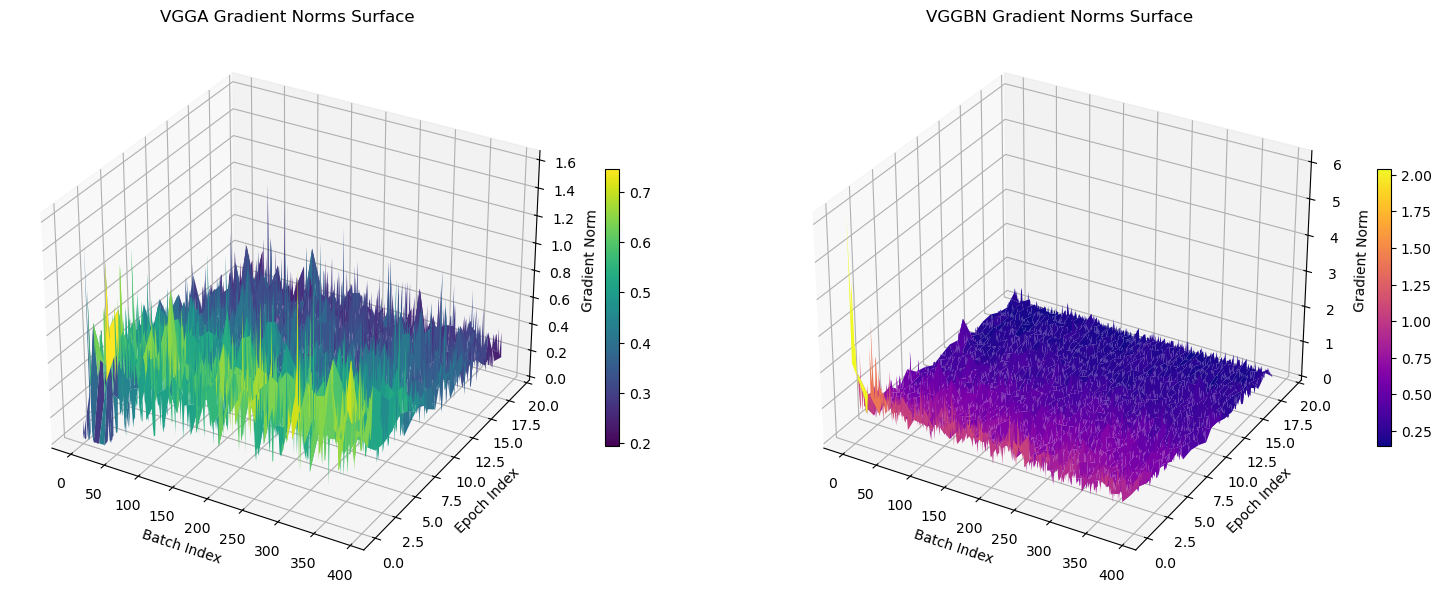

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 构建 meshgrid（必须 shape 一致）
epochs, batches = vgga_batch_norms.shape
X, Y = np.meshgrid(np.arange(batches), np.arange(epochs))

# 创建画布
fig = plt.figure(figsize=(16, 6))

# ------- 左图：VGGA -------
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X, Y, vgga_batch_norms, cmap='viridis', edgecolor='none')
ax1.set_title('VGGA Gradient Norms Surface')
ax1.set_xlabel('Batch Index')
ax1.set_ylabel('Epoch Index')
ax1.set_zlabel('Gradient Norm')
fig.colorbar(surf1, ax=ax1, shrink=0.5)

# ------- 右图：VGGBN -------
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X, Y, vggbn_batch_norms, cmap='plasma', edgecolor='none')
ax2.set_title('VGGBN Gradient Norms Surface')
ax2.set_xlabel('Batch Index')
ax2.set_ylabel('Epoch Index')
ax2.set_zlabel('Gradient Norm')
fig.colorbar(surf2, ax=ax2, shrink=0.5)

plt.tight_layout()
plt.show()

